<a href="https://colab.research.google.com/github/UgurUysal86/My-ML-Notebooks/blob/main/classification-image-data/ex-4/20240520_Detecting_Tanks_on_Images_Using_a_Pretrained_Object_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Ugur Uysal](https://github.com/UgurUysal86) - ugur.uysal.86@gmail.com - 20. MAY 2024
## Detecting Tanks on Images Using a Pretrained Object Detection Model

* This notebook demonstrates object detection on images with a pretrained neural network utilizing Tensorflow.

* Portions of this notebook are modifications based on work created and shared by Google (https://www.tensorflow.org/hub/tutorials/object_detection) and code samples are used according the [Apache 2.0 License](https://www.apache.org/licenses/LICENSE-2.0)

## 1. Import python packages

In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf
import tensorflow_hub as hub
print("Using Tensorflow Version", tf.__version__, "\n")

# For drawing onto and displaying the image.
from imageio.v2 import imread
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

Using Tensorflow Version 2.15.0 



## 2. **Loading** the pretrained neural network

the code below loads a pre-trained object detection model using TensorFlow Hub. You can choose between the Faster R-CNN model with the Inception ResNet V2 and mobilenet_v2 backbone from the OpenImages_v4 dataset.

These models are capable of detecting objects in images by providing bounding box coordinates and class labels. You can now use the detector to process images and identify objects.

Use [FasterRCNN_InceptionResNetV2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1) for higher accuracy

or

Use [mobilenet_v2](https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1) for faster inference.

In [ ]:
model  = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
detector = hub.load(model).signatures['default']

## 3. Setting parameters for detecting objects

The purpose of the provided code below is to set the parameters detecting objects on images.
* detection_min_score:
This threshold determines the minimum detection score required for an object to be considered valid. In your case, it’s set to 0.20 (20%).
* maxboxes:
This parameter specifies the maximum number of bounding boxes to display per image. You’ve set it to 10.
* detection_class_label:
The class label 384 corresponds to the class ‘tank’ in the OpenImages_v4 dataset.

In [ ]:
detection_min_score = 0.20 # detection threshold for objects
maxboxes = 10 # Maximum number of bounding boxex per image
detection_class_label = 384 # detection_class_labels 384 is class 'tank' in openimages_v4 dataset

## 4. Loading functions to predict and visualize bounding boxes on images with the loaded neural network

The purpose of the provided code below is to process images for object detection.
* draw_bounding_box_on_image Function:
Adds a bounding box to an image.
Calculates the dimensions of the bounding box based on normalized coordinates (ymin, xmin, ymax, xmax).
Draws the box using the specified color and font.
If display strings are provided, they are placed within the bounding box.
* draw_boxes Function:
Overlays labeled boxes on an image.
Iterates through bounding boxes.
Checks detection scores.
Displays class names along with the percentage score.
Uses the draw_bounding_box_on_image function to draw the boxes.
* run_detector Function:
Processes an image tensor using an unspecified detector.
Extracts class labels, scores, and bounding boxes.
Overlays the boxes on the input image.
* detect_objects_on_images Function:
Converts an input image (in BGR format) to RGB format.
Creates an image tensor.
Calls the detector to identify objects.
Displays the resulting image with overlaid bounding boxes.

In [ ]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=3, display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding box exceeds the top of the image, stack the strings below the bounding box instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),(left + text_width, text_bottom)],fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=maxboxes, min_score=detection_min_score):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


def run_detector(img_tensor, frame):
    detector_output = detector(img_tensor)
    detector_output = {key: value.numpy() for key, value in detector_output.items()}
    class_filter = np.where(detector_output["detection_class_labels"] == detection_class_label)
    detection_class_entities = (detector_output["detection_class_entities"][class_filter])[0:maxboxes]
    detection_scores = (detector_output["detection_scores"][class_filter])[0:maxboxes]
    detection_boxes = (detector_output["detection_boxes"][class_filter])[0:maxboxes]
    image_with_boxes = draw_boxes(frame, detection_boxes, detection_class_entities, detection_scores)
    #print(detector_output["detection_class_labels"])
    return image_with_boxes


def detect_objects_on_images(image_file):
    image = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
    img_tensor = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    cv2_imshow(run_detector(img_tensor, image))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## 5. Detect object on images provided with an URL

The provided code reads an image from a URL using the imread function. It then processes the image by invoking the detect_objects_on_images function, which uses a pre-trained model to detect tanks. The resulting image displays bounding boxes around the identified tanks, along with their prediction accuracy.

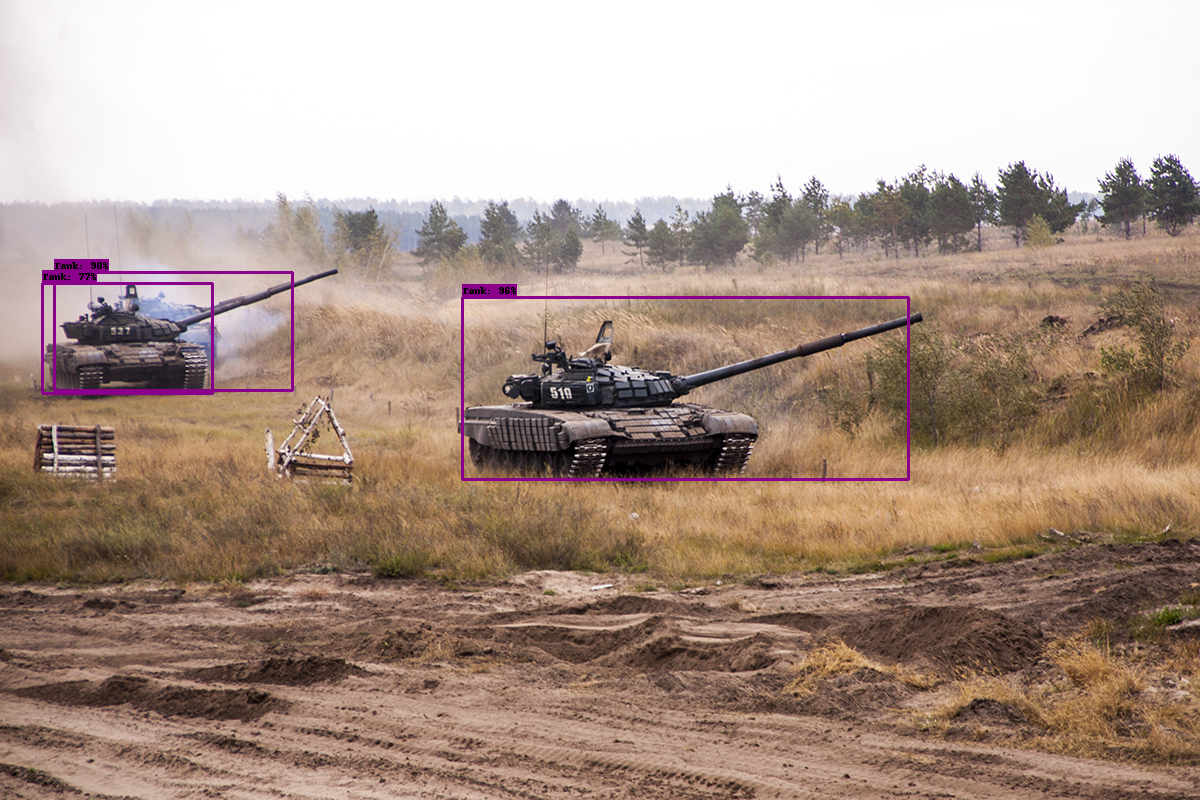

In [ ]:
# Provide a link to an image file
img = imread("https://upload.wikimedia.org/wikipedia/commons/c/cc/Tank_exercise_2017_in_Voronezh_Oblast_09.jpg")
# Image Reference: Mil.ru, Tank_exercise_2017_in_Voronezh_Oblast_09.jpg, CC BY 4.0, via Wikimedia Commons. Classnames, bounding boxes and prediction accuracy of class tank objects added to the image with the code in this notebook.

# detect objects on the image
detect_objects_on_images(img)

## References:
* https://www.tensorflow.org/hub/tutorials/object_detection
* https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/object_detection.ipynb
* https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1
* https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1
* https://upload.wikimedia.org/wikipedia/commons/c/cc/Tank_exercise_2017_in_Voronezh_Oblast_09.jpg

## License:
Copyright (c) 2024 Ugur Uysal

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Thank you. Visit my personal GitHub page https://github.com/UgurUysal86 for more examples.